## <center> CSC 578 Final Project (Spring 2019) </center>
### <center> Multivariate Temperature Forecasting using RNN/LSTM </center>
**Name:** Fangjing Zhan <br>
**Course/Section Number:** CSC 578-901 <br>
**Assignment Name:** Final Project -- Class Kaggle Competition<br>
**Kaggle User Name: Crystal Zhan**<br>
**Ranking:** 15

## Objective:
The task is to predict the temperature of the <b>next hour</b> based on the climate conditions and temperature over the last <b>24 hours</b>. This is a multivariate, timeseries forecasting problem.

## Table of contents:
1. Project and Data overview
2. Imports packages and data
3. Exploratory Data Analysis (EDA)
   1. Description Analysis
   2. Visualization Analysis
4. Data Preprocessing
   1. Normalize Data
   2. Concatenate training data to Keras RNN/-ready
   3. Split training data and validation data
   4. Reshape Input data
5. Model Building
   1. Build Base Model
   2. Train Models
   3. Optimal Models performance visualization
   4. Define final model
6. Predictions   
    
## 1. Project and Data overview:

The problem is a multivariate forecasting problem.  Given a historical data of climate conditions, you predict the temperature of the next hour based on the climate conditions and temperature over the last 24 hours. 

**Data**

The dataset contains weather conditions recorded at the Weather Station at the Max Planck Institute for Biogeochemistry in Jena, Germany, over several years. In this dataset, 14 different quantities (including air temperature, atmospheric pressure and humidity) were recorded every 10 minutes.

The original data goes back to 2003, but we use a subset for this competition, from 2009 to 2016 (both inclusive). Also for our competition, we use a further reduced version in which recordings are kept for every hour.


## 2. Imports packages and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler

#Handle annoying warnings
import warnings, sklearn.exceptions
warnings.filterwarnings("ignore")

import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Flatten, Dropout
from keras.layers import Bidirectional
from keras import optimizers
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from keras.callbacks import EarlyStopping

In [2]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['climate', 'sample']


In [3]:
# Load training dataset
df_train = pd.read_csv("../input/climate/climate_hour_train.csv")

#dfColumns = ['DateTime','p','T','Tpot','Tdew','rh','VPmax','VPact','VPdef','sh','H2OC','rho','wv','maxWv', 'wd']
#df.columns = dfColumns
df_train = df_train.set_index('Date Time')
print(df_train.info())
df_train.head()

<class 'pandas.core.frame.DataFrame'>
Index: 52566 entries, 01.01.2009 01:00:00 to 31.12.2014 23:00:00
Data columns (total 14 columns):
p (mbar)           52566 non-null float64
T (degC)           52566 non-null float64
Tpot (K)           52566 non-null float64
Tdew (degC)        52566 non-null float64
rh (%)             52566 non-null float64
VPmax (mbar)       52566 non-null float64
VPact (mbar)       52566 non-null float64
VPdef (mbar)       52566 non-null float64
sh (g/kg)          52566 non-null float64
H2OC (mmol/mol)    52566 non-null float64
rho (g/m**3)       52566 non-null float64
wv (m/s)           52566 non-null float64
max. wv (m/s)      52566 non-null float64
wd (deg)           52566 non-null float64
dtypes: float64(14)
memory usage: 6.0+ MB
None


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [4]:
# Load testing dataset
df_test = pd.read_csv("../input/climate/climate_Xtest.csv", header=None)
print(df_test.info())
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17447 entries, 0 to 17446
Columns: 336 entries, 0 to 335
dtypes: float64(336)
memory usage: 44.7 MB
None


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335
0,1007.19,2.06,274.65,1.89,98.8,7.09,7.00,0.09,4.34,6.95,1271.51,0.41,0.92,273.8,1007.06,2.22,274.82,2.06,98.9,7.17,7.09,0.08,4.39,7.04,1270.58,0.43,0.88,119.1,1007.43,2.04,274.61,1.87,98.8,7.08,6.99,0.08,4.33,6.94,1271.93,0.86,...,274.68,0.71,92.1,6.98,6.43,0.55,3.99,6.40,1268.90,2.03,3.71,174.4,1003.73,1.76,274.63,0.62,92.1,6.94,6.39,0.55,3.97,6.37,1268.80,0.54,1.52,137.1,1002.53,1.55,274.51,0.39,92.0,6.83,6.29,0.55,3.91,6.27,1268.31,3.10,4.61,157.8
1,1007.06,2.22,274.82,2.06,98.9,7.17,7.09,0.08,4.39,7.04,1270.58,0.43,0.88,119.1,1007.43,2.04,274.61,1.87,98.8,7.08,6.99,0.08,4.33,6.94,1271.93,0.86,1.64,145.9,1007.87,1.79,274.34,1.63,98.8,6.95,6.87,0.08,4.25,6.82,1273.66,0.82,...,274.63,0.62,92.1,6.94,6.39,0.55,3.97,6.37,1268.80,0.54,1.52,137.1,1002.53,1.55,274.51,0.39,92.0,6.83,6.29,0.55,3.91,6.27,1268.31,3.10,4.61,157.8,1001.61,1.77,274.80,0.28,89.8,6.94,6.23,0.71,3.88,6.22,1266.15,2.74,4.37,157.9
2,1007.43,2.04,274.61,1.87,98.8,7.08,6.99,0.08,4.33,6.94,1271.93,0.86,1.64,145.9,1007.87,1.79,274.34,1.63,98.8,6.95,6.87,0.08,4.25,6.82,1273.66,0.82,1.72,140.6,1007.79,2.12,274.66,1.99,99.1,7.12,7.05,0.06,4.36,7.00,1271.98,0.43,...,274.51,0.39,92.0,6.83,6.29,0.55,3.91,6.27,1268.31,3.10,4.61,157.8,1001.61,1.77,274.80,0.28,89.8,6.94,6.23,0.71,3.88,6.22,1266.15,2.74,4.37,157.9,1000.95,1.70,274.78,0.21,89.8,6.91,6.20,0.70,3.86,6.20,1265.64,1.05,2.68,135.9
3,1007.87,1.79,274.34,1.63,98.8,6.95,6.87,0.08,4.25,6.82,1273.66,0.82,1.72,140.6,1007.79,2.12,274.66,1.99,99.1,7.12,7.05,0.06,4.36,7.00,1271.98,0.43,1.04,86.2,1007.68,2.46,275.02,2.25,98.5,7.30,7.19,0.11,4.45,7.13,1270.17,0.24,...,274.80,0.28,89.8,6.94,6.23,0.71,3.88,6.22,1266.15,2.74,4.37,157.9,1000.95,1.70,274.78,0.21,89.8,6.91,6.20,0.70,3.86,6.20,1265.64,1.05,2.68,135.9,1000.25,1.84,274.98,0.21,88.9,6.98,6.20,0.77,3.87,6.20,1264.11,1.67,2.96,97.5
4,1007.79,2.12,274.66,1.99,99.1,7.12,7.05,0.06,4.36,7.00,1271.98,0.43,1.04,86.2,1007.68,2.46,275.02,2.25,98.5,7.30,7.19,0.11,4.45,7.13,1270.17,0.24,0.52,247.2,1007.53,1.93,274.50,1.64,97.9,7.02,6.88,0.15,4.26,6.82,1272.59,0.49,...,274.78,0.21,89.8,6.91,6.20,0.70,3.86,6.20,1265.64,1.05,2.68,135.9,1000.25,1.84,274.98,0.21,88.9,6.98,6.20,0.77,3.87,6.20,1264.11,1.67,2.96,97.5,998.95,2.41,275.66,-0.40,81.6,7.27,5.93,1.34,3.70,5.94,1259.97,2.36,4.45,161.3


## 3. Exploratory Data Analysis (EDA)
### 3-A. Description Analysis

In [5]:
# set dataframe df1 for training dataset visualization
df1 = df_train
df1.index = pd.to_datetime(df1.index)
#df1 = df1.set_index('Date Time')
df1.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,52566.000000,52566.000000,52566.000000,52566.000000,52566.000000,52566.000000,52566.000000,52566.000000,52566.000000,52566.000000,52566.000000,52566.000000,52566.000000,52566.000000
mean,988.723002,9.172795,283.254265,4.779049,76.444300,13.357483,9.458133,3.899249,5.977212,9.568031,1216.718989,2.142170,3.539017,173.689628
std,8.190684,8.533081,8.605048,6.922701,16.430164,7.572008,4.201679,4.723265,2.666892,4.253017,40.439912,1.530832,2.313246,87.251111
min,918.500000,-22.760000,250.850000,-24.800000,13.060000,0.970000,0.810000,0.000000,0.510000,0.810000,1066.190000,0.000000,0.000000,0.000000
25%,983.750000,3.110000,277.242500,0.130000,65.810000,7.640000,6.170000,0.810000,3.890000,6.240000,1188.082500,1.010000,1.800000,120.800000
50%,989.140000,9.310000,283.430000,5.200000,79.700000,11.740000,8.850000,2.090000,5.595000,8.965000,1213.440000,1.790000,3.000000,197.100000
75%,994.070000,15.280000,289.370000,10.030000,89.800000,17.390000,12.320000,5.130000,7.780000,12.450000,1243.050000,2.880000,4.750000,233.800000
max,1012.740000,35.480000,309.690000,22.940000,100.000000,57.800000,28.040000,41.710000,17.940000,28.530000,1392.560000,12.580000,20.330000,360.000000


From above description sheet, we can see the following facts:
- The 14 climate features are all float number with no missing value, the total number of instances in training set is 52556
- The scale of each feature are different, normalization of dataset is required at data preprocessing step
- Skewness can be observed by compare median (50%) and mean, and variable's distribution can be visualized in following histogram.

### 3-B. Visualization Analysis

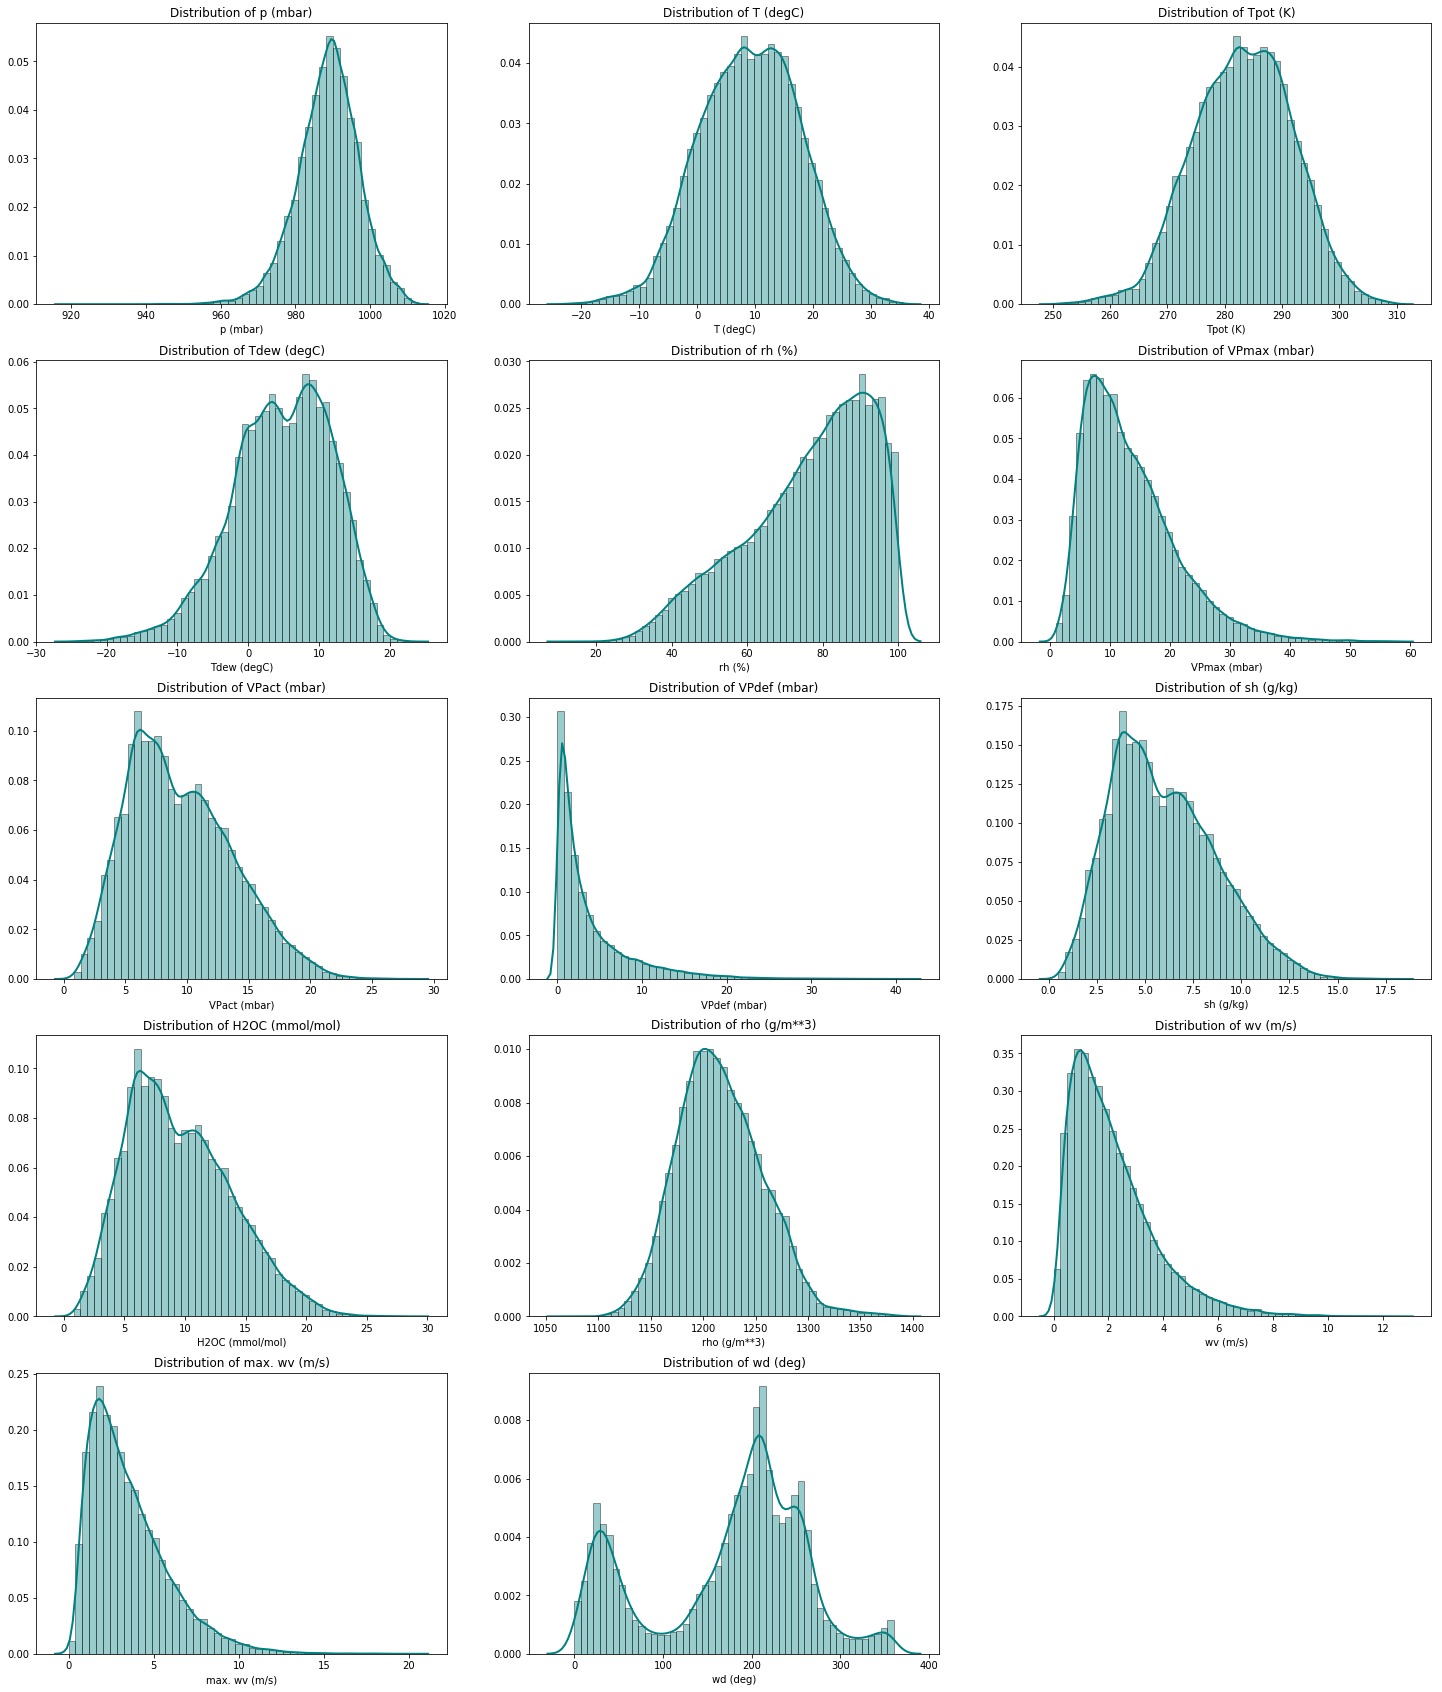

In [6]:
# Numerical Variables Distribution: Histogram and Kernel Density Estimate (KDE)
fig = plt.figure(figsize=(25,30))
for i in range(14):
    fig.add_subplot(5,3,i+1)
    sns.distplot(df1[df1.columns[i]], hist=True, color='teal',hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 2})
    plt.title("Distribution of {}".format(df1.columns[i]))

The above Histogram and Density plots show the following distribution pattern:
- Unimodal, close to normal distribution: T and Tpot
- Unimodal, skew to the left: p, Tdew, rh
- Unimodal, skew to the right: VPmax, VPact, VPdef, sh, H2OC, rho, wv, max.wv
- Bimodal: wd

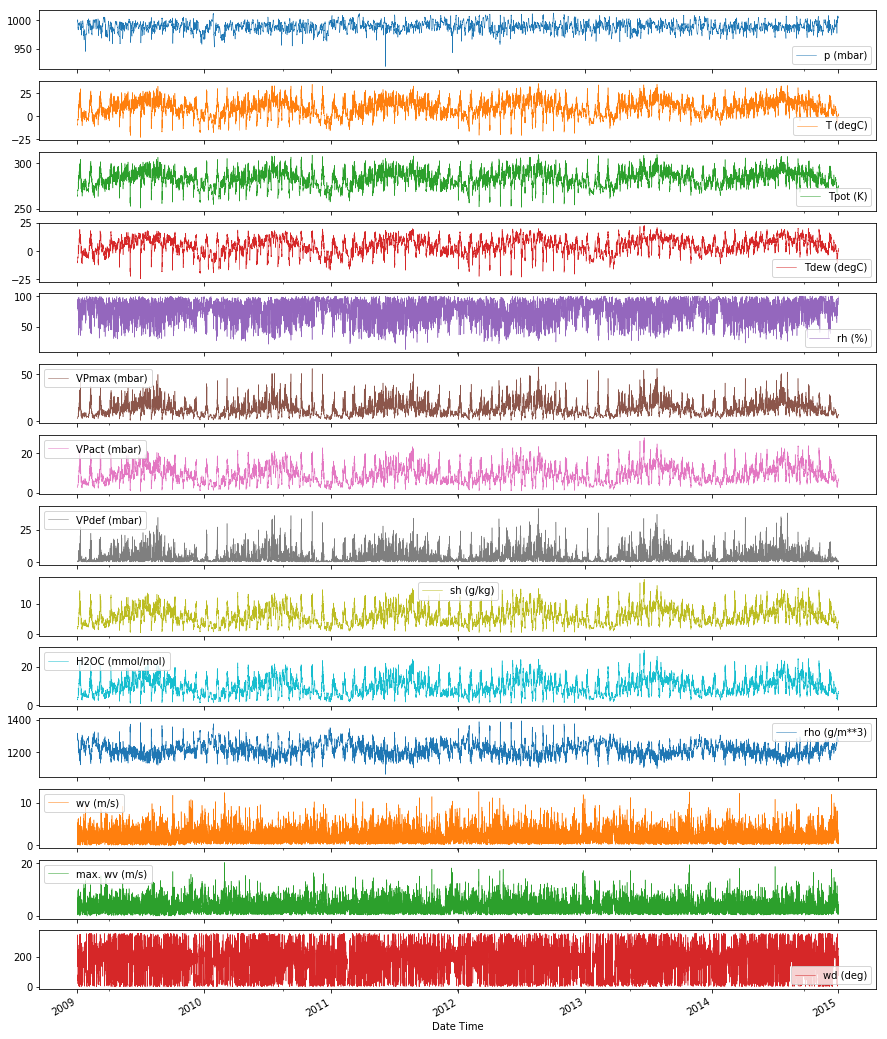

In [7]:
# Time Series of all the features
#dfColInd = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
axes = df1[df1.columns].plot(linewidth=0.5,  figsize=(15, 20), subplots=True)

From above plots, we can see the following 10 attributes show significant seasonality:
* T(degC)
* Tpot(K)
* Tdew(degC)
* rh(%)
* VPmax(mbar)
* VPact(mbar)
* VPdef(mbar)
* sh(g/kg)
* H2OC(mmol/mol) 
* rho(g/m**3) 

Next, let plot the Temperature time series to take a closer look at it

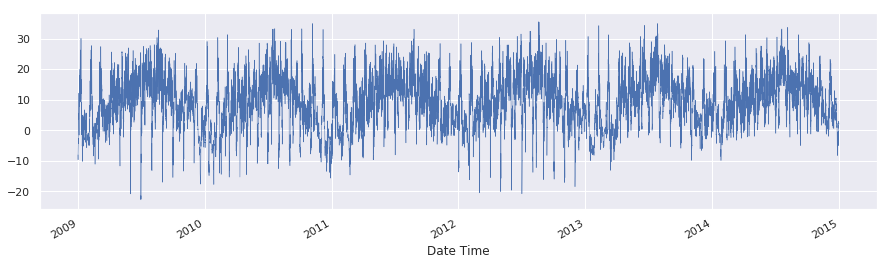

In [8]:
# Time Series of Temperature
sns.set(rc={'figure.figsize':(15, 4)})
df1['T (degC)'].plot(linewidth=0.5);

From above line plot of the full time series of Temperature, we can see the following interesting pattern:
 * The temperature fluctuate significant in year 2009 to 2013, and has small fluctuate in yearn 2013 to 2015;
 * The time series clearly exhibit seasonality, it oscillate between high and low values on a yearly time scale;

In [9]:
# Boxplot of Temperature by month and hour
df1['month'] = df1.index.month
df1['hour'] = df1.index.hour
df1.head(3)

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),month,hour
Date Time,,,,,,,,,,,,,,,,
2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7,1,1
2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3,1,2
2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2,1,3


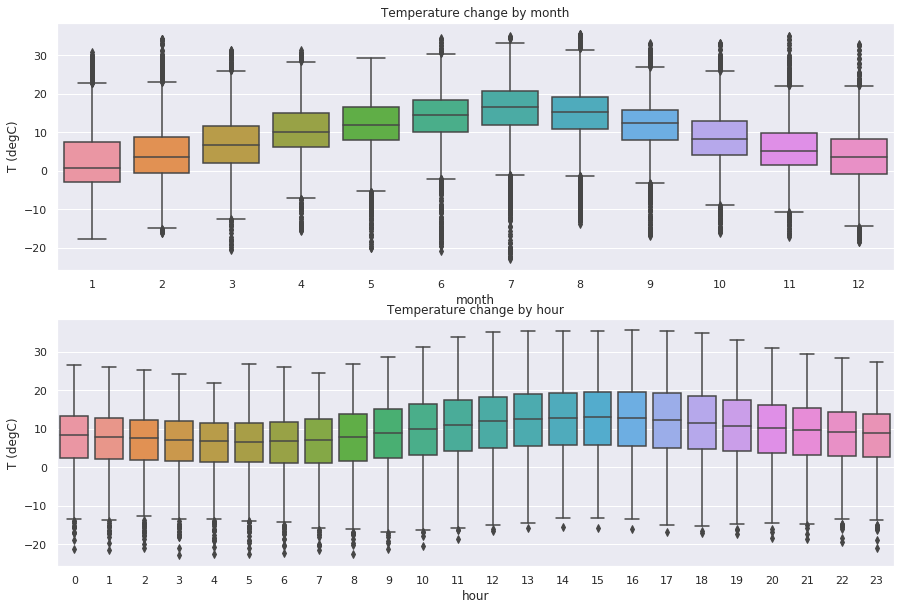

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=False)
for name, ax in zip(['month','hour'], axes):
    sns.boxplot(data=df1, x=name, y='T (degC)', ax=ax)
    ax.set_ylabel('T (degC)')
    ax.set_title('Temperature change by ' + name)

Next, we further explore the seasonality of Temperature with box plot, group the data by month and hour to display the distribution of each group.
- First we group the data by month, to visulize yearly seasonality, the boxplot confirm the yearly seasonality that we saw in earlier line plot and provide some additional insight:
    - Temperature is highest in July and lowest in January
    - The distribution of temperature have more outliers during summer
- Second, we group the temperature by hour of the day, to explore daily seasonality. From plot above we can see as what we expected, the temperature is slightly higher at noon than at night and morning. There are also less outlier in the middle of the day. 

## 4. Data Preprocessing
### 4-A. Normalize Data
Since the dot product (i.e., weighted sum) is susceptible to values of different magnitudes and/or ranges. We need normalize data before training model. Here we will use Standard Normal (Z-value) conversion: subtract the mean of each variable and divide by the standard deviation.<br>
**Note: Apply Normalization to both training and test dataset**

In [11]:
# Normalize training dataset
from sklearn.preprocessing import StandardScaler

# drop columns created in prevous visualization step
df_train = df_train.drop(['month','hour'], axis=1)
scaler = StandardScaler()
df_train_scaler = scaler.fit(df_train)
#print(df_train_scaler.mean_)
#print(df_train_scaler.scale_)
df_train_norm = df_train_scaler.transform(df_train)
df_train_norm = pd.DataFrame(df_train_norm)

df_train_norm.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.949502,-2.018375,-2.077203,-1.958654,1.092860,-1.324296,-1.503730,-0.785322,-1.506342,-1.509068,2.253761,-1.262182,-1.257560,0.217883
1,0.964153,-2.115644,-2.174821,-2.101663,1.019823,-1.352030,-1.560851,-0.781088,-1.562587,-1.565499,2.362318,-1.236053,-1.257560,0.190376
2,0.991013,-2.107441,-2.169011,-2.085774,1.038082,-1.350709,-1.553711,-0.783205,-1.555088,-1.558445,2.360587,-1.281780,-1.257560,-0.074379
3,1.009327,-2.135567,-2.198064,-2.137777,0.983305,-1.358633,-1.572751,-0.776853,-1.573836,-1.579607,2.395948,-1.334039,-1.365634,0.760002
4,1.066710,-2.203539,-2.270115,-2.228783,0.958959,-1.375802,-1.606071,-0.776853,-1.607584,-1.612525,2.484475,-1.138066,-1.149485,-0.191285


In [12]:
# Normalize test dataset
df_test_scaler = scaler.fit(df_test)
#print(df_test_scaler.mean_)
#print(df_test_scaler.scale_)
df_test_norm = df_test_scaler.transform(df_test)
df_test_norm = pd.DataFrame(df_test_norm)

df_test_norm.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335
0,1.903416,-1.025059,-1.173928,-0.592940,1.457023,-0.871958,-0.670693,-0.815798,-0.695286,-0.697433,1.495897,0.000265,-0.001998,1.124226,1.888403,-1.004967,-1.152892,-0.564826,1.463225,-0.862129,-0.648769,-0.817681,-0.676102,-0.675780,1.471460,0.000418,-0.002262,-0.704182,1.931027,-1.027314,-1.178570,-0.595945,1.457241,-0.873107,-0.672962,-0.817687,-0.698947,-0.699671,1.506438,0.003696,...,-1.168177,-0.783761,1.052600,-0.884804,-0.807321,-0.730005,-0.827308,-0.827558,1.425166,0.012622,0.016428,-0.050921,1.505770,-1.060526,-1.174241,-0.798381,1.052705,-0.889674,-0.816944,-0.730020,-0.834867,-0.834667,1.422473,0.001261,0.001969,-0.491620,1.367464,-1.086622,-1.188880,-0.835958,1.046736,-0.903104,-0.841106,-0.730031,-0.857686,-0.858530,1.409598,0.020782,0.022371,-0.247042
1,1.888433,-1.005078,-1.153020,-0.564969,1.463089,-0.862164,-0.648848,-0.817669,-0.676181,-0.675859,1.471649,0.000418,-0.002262,-0.704225,1.931044,-1.027444,-1.178719,-0.596085,1.457159,-0.873147,-0.673040,-0.817681,-0.699026,-0.699750,1.506655,0.003696,0.002756,-0.387413,1.981735,-1.058529,-1.211772,-0.635426,1.457241,-0.889021,-0.702086,-0.817687,-0.729512,-0.728434,1.551535,0.003391,...,-1.174320,-0.798537,1.052600,-0.889699,-0.817020,-0.730005,-0.834943,-0.834743,1.422562,0.001261,0.001968,-0.491790,1.367399,-1.086721,-1.188983,-0.836140,1.046635,-0.903136,-0.841191,-0.730020,-0.857770,-0.858614,1.409715,0.020782,0.022371,-0.246984,1.261376,-1.059180,-1.153257,-0.854014,0.913191,-0.889642,-0.855654,-0.700084,-0.869137,-0.870503,1.353364,0.018037,0.020787,-0.245860
2,1.931075,-1.027556,-1.178848,-0.596231,1.457023,-0.873182,-0.673120,-0.817669,-0.699107,-0.699830,1.506848,0.003697,0.002756,-0.387467,1.981753,-1.058662,-1.211924,-0.635570,1.457159,-0.889062,-0.702166,-0.817681,-0.729592,-0.728515,1.551757,0.003391,0.003284,-0.450057,1.972515,-1.017325,-1.172421,-0.576205,1.475441,-0.868210,-0.658400,-0.821430,-0.687486,-0.685290,1.507741,0.000417,...,-1.189062,-0.836299,1.046530,-0.903162,-0.841268,-0.730005,-0.857846,-0.858691,1.409804,0.020781,0.022370,-0.247125,1.261315,-1.059278,-1.153357,-0.854198,0.913094,-0.889674,-0.855739,-0.700073,-0.869221,-0.870587,1.353477,0.018037,0.020787,-0.245802,1.185270,-1.067911,-1.155714,-0.865504,0.913191,-0.893314,-0.862928,-0.701956,-0.876771,-0.875292,1.340086,0.005150,0.009628,-0.505860
3,1.981785,-1.058777,-1.212055,-0.635720,1.457023,-0.889098,-0.702247,-0.817669,-0.729674,-0.728596,1.551954,0.003392,0.003284,-0.450109,1.972533,-1.017455,-1.172570,-0.576343,1.475358,-0.868250,-0.658478,-0.821424,-0.687564,-0.685368,1.507959,0.000418,-0.001206,-1.093052,1.959838,-0.974871,-1.128151,-0.533433,1.439041,-0.846175,-0.624422,-0.812073,-0.653100,-0.654129,1.460559,-0.001031,...,-1.153435,-0.854359,0.912994,-0.889699,-0.855817,-0.700059,-0.869298,-0.870665,1.353563,0.018036,0.020786,-0.245943,1.185210,-1.068010,-1.155814,-0.865690,0.913094,-0.893345,-0.863013,-0.701944,-0.876855,-0.875377,1.340199,0.005150,0.009628,-0.505802,1.104551,-1.050449,-1.131145,-0.865504,0.858559,-0.884747,-0.862928,-0.688854,-0.872954,-0.875292,1.300253,0.009878,0.011477,-0.959678
4,1.972565,-1.017566,-1.172698,-0.576486,1.475222,-0.868285,-0.658557,-0.821412,-0.687644,-0.685447,1.508151,0.000418,-0.001206,-1.093081,1.959856,-0.974998,-1.128296,-0.533567,1.438959,-0.846214,-0.624498,-0.812067,-0.653177,-0.654206,1.460772,-0.001031,-0.004639,0.809929,1.942551,-1.041049,-1.192097,-0.633781,1.402640,-0.880452,-0.699659,-0.804587,-0.725691,-0.728434,1.523642,0.000875,...,-1.155892,-0.865852,0.912994,-0.893371,-0.863092,-0.701930,-0.876932,-0.875454,1.340284,0.005150,0.009627,-0.505973,1.104494,-1.050546,-1.131245,-0.865690,0.858464,-0.884778,-0.863013,-0.688843,-0.873038,-0.875377,1

### 4-B. Concatenate training data to Keras RNN/-ready

Our forecasting scheme is to look back 24 hours (e.g. h1 through h24) and predict the next hour (h25).  And we use all 14 climate measurements of the previous 24 hours to predict the temperature (only) of the 24th hour (thus just one feature). 
The dataset -- xtrain and ytrain are as follow:
- xtrain:
    - Shape: 52542 x 336 (where 52542 = 52566 - 24, 336 = 14 * 24)
    - The first entry in xtrain spans from 01.01.2009 01:00:00 to 02.01.2009 00:00:00
    - The last entry in xtrain spans from 30.12.2014 23:00:00 to 31.12.2014 22:00:00
- ytrain:
    - Shape: 52542 * 1
    - The first entry in ytrain is the temperature of 02.01.2009 01:00:00
    - The last entry in ytrain is the temperature of 31.12.2014 23:00:00

In [13]:
df_train_norm.to_csv('train_norm.csv', index=False, header=False)

In [14]:
def series_to_supervised(data, n_in=24,  dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t,t+1 ... t+n)
    for i in range(n_in+1):
        cols.append(df.shift(-i))
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [15]:
# Generate dataset contains both the first 24 hours and the next hour climate features, 
# The output dataset contains: 25*14=350 columns and 52566-24=52542 rows
df_agg = series_to_supervised(df_train_norm)
print(df_agg.shape)
df_agg.head()

(52542, 350)


,var1(t+0),var2(t+0),var3(t+0),var4(t+0),var5(t+0),var6(t+0),var7(t+0),var8(t+0),var9(t+0),var10(t+0),var11(t+0),var12(t+0),var13(t+0),var14(t+0),var1(t+1),var2(t+1),var3(t+1),var4(t+1),var5(t+1),var6(t+1),var7(t+1),var8(t+1),var9(t+1),var10(t+1),var11(t+1),var12(t+1),var13(t+1),var14(t+1),var1(t+2),var2(t+2),var3(t+2),var4(t+2),var5(t+2),var6(t+2),var7(t+2),var8(t+2),var9(t+2),var10(t+2),var11(t+2),var12(t+2),...,var3(t+22),var4(t+22),var5(t+22),var6(t+22),var7(t+22),var8(t+22),var9(t+22),var10(t+22),var11(t+22),var12(t+22),var13(t+22),var14(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23),var5(t+23),var6(t+23),var7(t+23),var8(t+23),var9(t+23),var10(t+23),var11(t+23),var12(t+23),var13(t+23),var14(t+23),var1(t+24),var2(t+24),var3(t+24),var4(t+24),var5(t+24),var6(t+24),var7(t+24),var8(t+24),var9(t+24),var10(t+24),var11(t+24),var12(t+24),var13(t+24),var14(t+24)
0,0.949502,-2.018375,-2.077203,-1.958654,1.092860,-1.324296,-1.503730,-0.785322,-1.506342,-1.509068,2.253761,-1.262182,-1.257560,0.217883,0.964153,-2.115644,-2.174821,-2.101663,1.019823,-1.352030,-1.560851,-0.781088,-1.562587,-1.565499,2.362318,-1.236053,-1.257560,0.190376,0.991013,-2.107441,-2.169011,-2.085774,1.038082,-1.350709,-1.553711,-0.783205,-1.555088,-1.558445,2.360587,-1.281780,...,-1.690217,-1.533961,0.831144,-1.185626,-1.310948,-0.734509,-1.318856,-1.320965,1.918198,-0.974754,-1.097610,0.522753,1.326764,-1.607031,-1.697190,-1.479068,1.019823,-1.188267,-1.284768,-0.762033,-1.292608,-1.295100,1.919187,-1.131533,-1.149485,-0.214207,1.296241,-1.595312,-1.683245,-1.440066,1.092860,-1.184305,-1.263348,-0.772619,-1.273859,-1.273939,1.897921,-1.216455,-1.097610,-0.293290
1,0.964153,-2.115644,-2.174821,-2.101663,1.019823,-1.352030,-1.560851,-0.781088,-1.562587,-1.565499,2.362318,-1.236053,-1.257560,0.190376,0.991013,-2.107441,-2.169011,-2.085774,1.038082,-1.350709,-1.553711,-0.783205,-1.555088,-1.558445,2.360587,-1.281780,-1.257560,-0.074379,1.009327,-2.135567,-2.198064,-2.137777,0.983305,-1.358633,-1.572751,-0.776853,-1.573836,-1.579607,2.395948,-1.334039,...,-1.697190,-1.479068,1.019823,-1.188267,-1.284768,-0.762033,-1.292608,-1.295100,1.919187,-1.131533,-1.149485,-0.214207,1.296241,-1.595312,-1.683245,-1.440066,1.092860,-1.184305,-1.263348,-0.772619,-1.273859,-1.273939,1.897921,-1.216455,-1.097610,-0.293290,1.246183,-1.577733,-1.662327,-1.418398,1.098947,-1.177702,-1.251448,-0.774736,-1.258860,-1.262182,1.867010,-1.079274,-1.149485,0.413871
2,0.991013,-2.107441,-2.169011,-2.085774,1.038082,-1.350709,-1.553711,-0.783205,-1.555088,-1.558445,2.360587,-1.281780,-1.257560,-0.074379,1.009327,-2.135567,-2.198064,-2.137777,0.983305,-1.358633,-1.572751,-0.776853,-1.573836,-1.579607,2.395948,-1.334039,-1.365634,0.760002,1.066710,-2.203539,-2.270115,-2.228783,0.958959,-1.375802,-1.606071,-0.776853,-1.607584,-1.612525,2.484475,-1.138066,...,-1.683245,-1.440066,1.092860,-1.184305,-1.263348,-0.772619,-1.273859,-1.273939,1.897921,-1.216455,-1.097610,-0.293290,1.246183,-1.577733,-1.662327,-1.418398,1.098947,-1.177702,-1.251448,-0.774736,-1.258860,-1.262182,1.867010,-1.079274,-1.149485,0.413871,1.216882,-1.596484,-1.678596,-1.434287,1.117206,-1.184305,-1.260968,-0.776853,-1.270109,-1.271587,1.878632,-0.974754,-1.097610,0.339373
3,1.009327,-2.135567,-2.198064,-2.137777,0.983305,-1.358633,-1.572751,-0.776853,-1.573836,-1.579607,2.395948,-1.334039,-1.365634,0.760002,1.066710,-2.203539,-2.270115,-2.228783,0.958959,-1.375802,-1.606071,-0.776853,-1.607584,-1.612525,2.484475,-1.138066,-1.149485,-0.191285,1.097232,-2.208226,-2.277088,-2.224449,0.989391,-1.377122,-1.606071,-0.781088,-1.607584,-1.610174,2.497334,-1.366702,...,-1.662327,-1.418398,1.098947,-1.177702,-1.251448,-0.774736,-1.258860,-1.262182,1.867010,-1.079274,-1.149485,0.413871,1.216882,-1.596484,-1.678596,-1.434287,1.117206,-1.184305,-1.260968,-0.776853,-1.270109,-1.271587,1.878632,-0.974754,-1.097610,0.339373,1.171708,-1.611719,-1.690217,-1.444399,1.141552,-1.190909,-1.265728,-0.781088,-1.273859,-1.276290,1.882094,-0.896365,-0

In [16]:
# Get xtrain and ytrain
xtrain = df_agg.iloc[:,0:336]
ytrain = pd.DataFrame(df_agg['var2(t+24)'])
xtrain.columns=range(xtrain.shape[1])
ytrain.columns=range(ytrain.shape[1])
print('xtrain shape is: ', xtrain.shape)
print('ytrain shape is: ', ytrain.shape)

xtrain shape is:  (52542, 336)
ytrain shape is:  (52542, 1)


### 4-C. Split training data and validation data
Split the training data into 2 parts: the first 5 year for training predictive models and the final year for evaluating models.
- x_valid:
    - Shape: 8760 x 336 (where 8760 = 365 * 24)
    - Entry from 01.01.2014 01:00:00 to 31.12.2014 23:00:00
- y_valid:
    - Shape: 8760 x 1
    - Entry from 01.01.2014 01:00:00 to 31.12.2014 23:00:00
- x_train:
    - Shape: 43782 x 336 (where 43782 = 52542 - 8760)
    - Entry from 01.01.2009 01:00:00 to 31.12.2013 23:00:00
- y_train:
    - Shape: 43782 x 1
    - Entry from 01.01.2009 01:00:00 to 31.12.2013 23:00:00

In [17]:
#Split training and validation data
idx = 43782
x_train, x_valid = xtrain.iloc[:idx,:], xtrain.iloc[idx:,:]
y_train, y_valid = ytrain.iloc[:idx,:], ytrain.iloc[idx:,:]

#from sklearn.model_selection import train_test_split
#x_train, x_valid, y_train, y_valid = train_test_split(xtrain_3D, ytrain,test_size=0.1,random_state=33)
print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape )

(43782, 336) (8760, 336) (43782, 1) (8760, 1)


### 4-D. Reshape Input data
Reshape training, validation and testing input data into 3D format expected by LSTMs, namely [samples, timesteps, features]

In [18]:
# Reshape input to be 3D [samples, timesteps, features]
x_train = x_train.values.reshape((x_train.values.shape[0], 24, int(x_train.values.shape[1]/24)))
x_valid = x_valid.values.reshape((x_valid.values.shape[0], 24, int(x_valid.values.shape[1]/24)))
x_test = df_test_norm.values.reshape((df_test_norm.values.shape[0], 24, int(df_test_norm.values.shape[1]/24)))

print(x_train.shape, x_valid.shape, x_test.shape)

(43782, 24, 14) (8760, 24, 14) (17447, 24, 14)


## 5. Model Building


In [19]:
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Flatten, Dropout
from keras.layers import Conv1D
from keras.layers import Bidirectional
from keras import optimizers

from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [20]:
timesteps = 24
data_dim = 14

### 5-A. Build Base Model 
In this step, I will define a Vanilla LSTM model as the base model. 
* Single hidden LSTM layer with 50 units, the input shape will be 24 time steps with 14 features
* Then, an output layer with 1 element
* We will use MAE (Mean Absolute Error) loss function and the efficient Adam version of stochastic gradient descent
* The model will be fit for 50 training epochs with a batch size of 1000

In [29]:
# design network
base_model = Sequential()
base_model.add(LSTM(50, input_shape=(timesteps, data_dim)))
base_model.add(Dense(1, activation='linear'))

base_model.compile(loss='mae', optimizer='adam')

# fit network
base_history = base_model.fit(x_train, y_train, batch_size=1000,  epochs=50, validation_data=(x_valid, y_valid), shuffle=False)

Train on 43782 samples, validate on 8760 samples
Epoch 1/50
43782/43782 [==============================] - 3s 75us/step - loss: 0.3989 - val_loss: 0.1766
Epoch 2/50
43782/43782 [==============================] - 2s 49us/step - loss: 0.1565 - val_loss: 0.1293
Epoch 3/50
43782/43782 [==============================] - 2s 50us/step - loss: 0.1247 - val_loss: 0.1259
Epoch 4/50
43782/43782 [==============================] - 2s 51us/step - loss: 0.1110 - val_loss: 0.1098
Epoch 5/50
43782/43782 [==============================] - 2s 50us/step - loss: 0.1059 - val_loss: 0.0940
Epoch 6/50
43782/43782 [==============================] - 2s 49us/step - loss: 0.1048 - val_loss: 0.0885
Epoch 7/50
43782/43782 [==============================] - 2s 49us/step - loss: 0.0919 - val_loss: 0.0834
Epoch 8/50
43782/43782 [==============================] - 2s 50us/step - loss: 0.0820 - val_loss: 0.0808
Epoch 9/50
43782/43782 [==============================] - 2s 50us/step - loss: 0.0905 - val_loss: 0.0785
Epoch 

~~~python
base_model
Epoch 48/50
43782/43782 [==============================] - 2s 50us/step - loss: 0.0569 - val_loss: 0.0612
Epoch 49/50
43782/43782 [==============================] - 2s 51us/step - loss: 0.0624 - val_loss: 0.0596
Epoch 50/50
43782/43782 [==============================] - 2s 50us/step - loss: 0.0570 - val_loss: 0.0624
~~~

In [22]:
# create a link to download the dataframe which was saved with .to_csv method
from IPython.display import HTML
def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

In [31]:
# Make prediction
me = 10.25075
std = 8.01432
y_test = pd.read_csv('../input/sample/sample_submission_2019spring.csv')

y_test['temperature'] = base_model.predict(x_test)
y_test['temperature'] = y_test['temperature']*std+me
y_test.to_csv("base_output.csv", index = False)

create_download_link(filename='"base_output.csv".csv')

### 5-B Train Models
**t1_model**
 * Stacked LSTM: Add 1 LSTM layer, 1st and 2nd LSTM node number all set to 50
 * Set 1st LSTM return_sequences = True, this allows to have 3D output from 1st LSTM as input to the next

In [30]:
t1_model = Sequential()
t1_model.add(LSTM(50, return_sequences=True, input_shape=(timesteps, data_dim)))
t1_model.add(LSTM(50))
t1_model.add(Dense(1, activation='linear'))

#adam=optimizers.Adam(lr=0.001, beta_1=0.90, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
t1_model.compile(loss='mae', optimizer='adam')

# fit network
t1_history = t1_model.fit(x_train, y_train, batch_size=1000,  epochs=50, validation_data=(x_valid, y_valid), shuffle=False)

Train on 43782 samples, validate on 8760 samples
Epoch 1/50
43782/43782 [==============================] - 6s 143us/step - loss: 0.3897 - val_loss: 0.2624
Epoch 2/50
43782/43782 [==============================] - 4s 95us/step - loss: 0.2242 - val_loss: 0.1956
Epoch 3/50
43782/43782 [==============================] - 4s 95us/step - loss: 0.1693 - val_loss: 0.1537
Epoch 4/50
43782/43782 [==============================] - 4s 95us/step - loss: 0.1619 - val_loss: 0.1253
Epoch 5/50
43782/43782 [==============================] - 4s 96us/step - loss: 0.1320 - val_loss: 0.1280
Epoch 6/50
43782/43782 [==============================] - 4s 95us/step - loss: 0.1547 - val_loss: 0.1533
Epoch 7/50
43782/43782 [==============================] - 4s 94us/step - loss: 0.1263 - val_loss: 0.1137
Epoch 8/50
43782/43782 [==============================] - 4s 95us/step - loss: 0.1080 - val_loss: 0.1030
Epoch 9/50
43782/43782 [==============================] - 4s 94us/step - loss: 0.1075 - val_loss: 0.1122
Epoch

```python
Epoch 48/50
43782/43782 [==============================] - 4s 92us/step - loss: 0.0562 - val_loss: 0.0564
Epoch 49/50
43782/43782 [==============================] - 4s 92us/step - loss: 0.0654 - val_loss: 0.0657
Epoch 50/50
43782/43782 [==============================] - 4s 96us/step - loss: 0.0646 - val_loss: 0.0620
```

In [32]:
# Make prediction
me = 10.25075
std = 8.01432
y_test = pd.read_csv('../input/sample/sample_submission_2019spring.csv')

y_test['temperature'] = t1_model.predict(x_test)
y_test['temperature'] = y_test['temperature']*std+me
y_test.to_csv("t1_output.csv", index = False)

create_download_link(filename='"t1_output.csv".csv')

**t2_model**
* Stacked LSTM: Add 2 LSTM layers, all LSTM unit number set to be 50
* Set 1st and 2nd LSTM return_sequences = True

In [33]:
t2_model = Sequential()
t2_model.add(LSTM(50, return_sequences=True, input_shape=(timesteps, data_dim)))
t2_model.add(LSTM(50, return_sequences=True))
t2_model.add(LSTM(50))
t2_model.add(Dense(1, activation='linear'))

#adam=optimizers.Adam(lr=0.001, beta_1=0.90, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
t2_model.compile(loss='mae', optimizer='adam')

# fit network
t2_history = t2_model.fit(x_train, y_train, batch_size=1000,  epochs=50, validation_data=(x_valid, y_valid), shuffle=False)

Train on 43782 samples, validate on 8760 samples
Epoch 1/50
43782/43782 [==============================] - 9s 206us/step - loss: 0.4140 - val_loss: 0.3564
Epoch 2/50
43782/43782 [==============================] - 6s 140us/step - loss: 0.3072 - val_loss: 0.2322
Epoch 3/50
43782/43782 [==============================] - 6s 142us/step - loss: 0.2165 - val_loss: 0.1982
Epoch 4/50
43782/43782 [==============================] - 6s 142us/step - loss: 0.2330 - val_loss: 0.2004
Epoch 5/50
43782/43782 [==============================] - 6s 142us/step - loss: 0.1809 - val_loss: 0.1798
Epoch 6/50
43782/43782 [==============================] - 6s 142us/step - loss: 0.1737 - val_loss: 0.1409
Epoch 7/50
43782/43782 [==============================] - 6s 141us/step - loss: 0.1561 - val_loss: 0.1285
Epoch 8/50
43782/43782 [==============================] - 6s 141us/step - loss: 0.1449 - val_loss: 0.1189
Epoch 9/50
43782/43782 [==============================] - 6s 142us/step - loss: 0.1328 - val_loss: 0.11

~~~python
t2_model
Epoch 48/50
43782/43782 [==============================] - 6s 139us/step - loss: 0.0759 - val_loss: 0.0727
Epoch 49/50
43782/43782 [==============================] - 6s 139us/step - loss: 0.0756 - val_loss: 0.0605
Epoch 50/50
43782/43782 [==============================] - 6s 140us/step - loss: 0.0626 - val_loss: 0.0629
~~~

In [34]:
y_test = pd.read_csv('../input/sample/sample_submission_2019spring.csv')

y_test['temperature'] = t2_model.predict(x_test)
y_test['temperature'] = y_test['temperature']*std+me
y_test.to_csv("t2_output.csv", index = False)

create_download_link(filename='"t2_output.csv".csv')

**t3_model**
* Bidirectional LSTM: Change LSTM layer to bidirectional LSTM

In [35]:
t3_model = Sequential()
t3_model.add(Bidirectional(LSTM(50), input_shape=(timesteps, data_dim)))
t3_model.add(Dense(1, activation='linear'))

t3_model.compile(loss='mae', optimizer='adam')

# fit network
t3_history = t3_model.fit(x_train, y_train, batch_size=1000,  epochs=50, validation_data=(x_valid, y_valid), shuffle=False)

Train on 43782 samples, validate on 8760 samples
Epoch 1/50
43782/43782 [==============================] - 7s 160us/step - loss: 0.3290 - val_loss: 0.1749
Epoch 2/50
43782/43782 [==============================] - 4s 94us/step - loss: 0.1609 - val_loss: 0.1418
Epoch 3/50
43782/43782 [==============================] - 4s 95us/step - loss: 0.1434 - val_loss: 0.1154
Epoch 4/50
43782/43782 [==============================] - 4s 96us/step - loss: 0.1337 - val_loss: 0.1069
Epoch 5/50
43782/43782 [==============================] - 4s 95us/step - loss: 0.1191 - val_loss: 0.1010
Epoch 6/50
43782/43782 [==============================] - 4s 96us/step - loss: 0.1064 - val_loss: 0.0945
Epoch 7/50
43782/43782 [==============================] - 4s 93us/step - loss: 0.1047 - val_loss: 0.0908
Epoch 8/50
43782/43782 [==============================] - 4s 95us/step - loss: 0.0987 - val_loss: 0.0885
Epoch 9/50
43782/43782 [==============================] - 4s 93us/step - loss: 0.0860 - val_loss: 0.0901
Epoch

~~~python
t3_model
Epoch 48/50
43782/43782 [==============================] - 4s 90us/step - loss: 0.0630 - val_loss: 0.0577
Epoch 49/50
43782/43782 [==============================] - 4s 91us/step - loss: 0.0578 - val_loss: 0.0628
Epoch 50/50
43782/43782 [==============================] - 4s 90us/step - loss: 0.0629 - val_loss: 0.0578
~~~

In [36]:
y_test = pd.read_csv('../input/sample/sample_submission_2019spring.csv')

y_test['temperature'] = t3_model.predict(x_test)
y_test['temperature'] = y_test['temperature']*std+me
y_test.to_csv("t3_output.csv", index = False)

create_download_link(filename='"t3_output.csv".csv')

**t4_model**
* CNN-LSTM
* Reshape x_train and x_valid
* Add a convolution layer, set filter=64, kernel_size = 1, timesteps = double of original timesteps(24)
* Add a max pooling layer set pool_size=2
* Add a flatten layer

In [37]:
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# Reshape x_train, x_valid from [samples, timesteps, features] into [samples, subsequences, timesteps, features]
x_train_cnn = x_train.reshape(x_train.shape[0], 1, 24, 14)
x_valid_cnn = x_valid.reshape(x_valid.shape[0], 1, 24, 14)

# Define model
t4_model = Sequential()
t4_model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, timesteps, data_dim)))
t4_model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
t4_model.add(TimeDistributed(Flatten()))
t4_model.add(LSTM(50))
t4_model.add(Dense(1, activation='linear'))
t4_model.compile(optimizer='adam', loss='mae')

t4_history = t4_model.fit(x_train_cnn, y_train, batch_size=1000,  epochs=50, validation_data=(x_valid_cnn, y_valid), shuffle=False)

Train on 43782 samples, validate on 8760 samples
Epoch 1/50
43782/43782 [==============================] - 4s 99us/step - loss: 0.4164 - val_loss: 0.2327
Epoch 2/50
43782/43782 [==============================] - 0s 9us/step - loss: 0.2409 - val_loss: 0.1765
Epoch 3/50
43782/43782 [==============================] - 0s 9us/step - loss: 0.1974 - val_loss: 0.2126
Epoch 4/50
43782/43782 [==============================] - 0s 10us/step - loss: 0.2232 - val_loss: 0.1446
Epoch 5/50
43782/43782 [==============================] - 0s 9us/step - loss: 0.1891 - val_loss: 0.1385
Epoch 6/50
43782/43782 [==============================] - 0s 10us/step - loss: 0.1655 - val_loss: 0.1341
Epoch 7/50
43782/43782 [==============================] - 0s 10us/step - loss: 0.1493 - val_loss: 0.1534
Epoch 8/50
43782/43782 [==============================] - 0s 10us/step - loss: 0.1519 - val_loss: 0.1585
Epoch 9/50
43782/43782 [==============================] - 0s 10us/step - loss: 0.1493 - val_loss: 0.1305
Epoch 10/

~~~python
t4_model
Epoch 48/50
43782/43782 [==============================] - 0s 10us/step - loss: 0.0966 - val_loss: 0.0860
Epoch 49/50
43782/43782 [==============================] - 0s 10us/step - loss: 0.0999 - val_loss: 0.0856
Epoch 50/50
43782/43782 [==============================] - 0s 10us/step - loss: 0.0987 - val_loss: 0.0824
~~~

In [38]:
y_test = pd.read_csv('../input/sample/sample_submission_2019spring.csv')
x_test_cnn = x_test.reshape(x_test.shape[0], 1, 24, 14)

y_test['temperature'] = t4_model.predict(x_test_cnn)
y_test['temperature'] = y_test['temperature']*std+me
y_test.to_csv("t4_output.csv", index = False)

create_download_link(filename='"t4_output.csv".csv')

**t5_model**
* CNN-1 Bidirectional LSTM 

In [39]:
# Reshape x_train, x_valid from [samples, timesteps, features] into [samples, subsequences, timesteps, features]
x_train_cnn = x_train.reshape(x_train.shape[0], 1, 24, 14)
x_valid_cnn = x_valid.reshape(x_valid.shape[0], 1, 24, 14)

# Define model
t5_model = Sequential()
t5_model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, timesteps, data_dim)))
t5_model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
t5_model.add(TimeDistributed(Flatten()))
t5_model.add(Bidirectional(LSTM(50)))
t5_model.add(Dense(1, activation='linear'))
t5_model.compile(optimizer='adam', loss='mae')

t5_history = t5_model.fit(x_train_cnn, y_train, batch_size=1000,  epochs=50, validation_data=(x_valid_cnn, y_valid), shuffle=False)

Train on 43782 samples, validate on 8760 samples
Epoch 1/50
43782/43782 [==============================] - 4s 98us/step - loss: 0.4536 - val_loss: 0.2538
Epoch 2/50
43782/43782 [==============================] - 1s 12us/step - loss: 0.2332 - val_loss: 0.2477
Epoch 3/50
43782/43782 [==============================] - 1s 12us/step - loss: 0.2331 - val_loss: 0.1525
Epoch 4/50
43782/43782 [==============================] - 1s 12us/step - loss: 0.1938 - val_loss: 0.1462
Epoch 5/50
43782/43782 [==============================] - 1s 12us/step - loss: 0.1776 - val_loss: 0.1419
Epoch 6/50
43782/43782 [==============================] - 1s 12us/step - loss: 0.1683 - val_loss: 0.1400
Epoch 7/50
43782/43782 [==============================] - 1s 12us/step - loss: 0.1617 - val_loss: 0.1307
Epoch 8/50
43782/43782 [==============================] - 1s 12us/step - loss: 0.1711 - val_loss: 0.1490
Epoch 9/50
43782/43782 [==============================] - 1s 12us/step - loss: 0.1488 - val_loss: 0.1296
Epoch 

~~~python
t5_model
Epoch 48/50
43782/43782 [==============================] - 1s 12us/step - loss: 0.1085 - val_loss: 0.0985
Epoch 49/50
43782/43782 [==============================] - 1s 12us/step - loss: 0.0882 - val_loss: 0.0835
Epoch 50/50
43782/43782 [==============================] - 1s 12us/step - loss: 0.1022 - val_loss: 0.0969
~~~

In [40]:
y_test = pd.read_csv('../input/sample/sample_submission_2019spring.csv')
x_test_cnn = x_test.reshape(x_test.shape[0], 1, 24, 14)

y_test['temperature'] = t5_model.predict(x_test_cnn)
y_test['temperature'] = y_test['temperature']*std+me
y_test.to_csv("t5_output.csv", index = False)

create_download_link(filename='"t5_output.csv".csv')

**t6_model**
* CNN-3 Bidirectional LSTM 

In [41]:
# Reshape x_train, x_valid from [samples, timesteps, features] into [samples, subsequences, timesteps, features]
x_train_cnn = x_train.reshape(x_train.shape[0], 1, 24, 14)
x_valid_cnn = x_valid.reshape(x_valid.shape[0], 1, 24, 14)

# Define model
t6_model = Sequential()
t6_model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, timesteps, data_dim)))
t6_model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
t6_model.add(TimeDistributed(Flatten()))
t6_model.add(Bidirectional(LSTM(50, return_sequences=True)))
t6_model.add(Bidirectional(LSTM(50, return_sequences=True)))
t6_model.add(Bidirectional(LSTM(50)))
t6_model.add(Dense(1, activation='linear'))
t6_model.compile(optimizer='adam', loss='mae')

t6_history = t6_model.fit(x_train_cnn, y_train, batch_size=1000,  epochs=50, validation_data=(x_valid_cnn, y_valid), shuffle=False)

Train on 43782 samples, validate on 8760 samples
Epoch 1/50
43782/43782 [==============================] - 8s 182us/step - loss: 0.5424 - val_loss: 0.3046
Epoch 2/50
43782/43782 [==============================] - 1s 25us/step - loss: 0.3161 - val_loss: 0.3056
Epoch 3/50
43782/43782 [==============================] - 1s 24us/step - loss: 0.2534 - val_loss: 0.1624
Epoch 4/50
43782/43782 [==============================] - 1s 24us/step - loss: 0.2080 - val_loss: 0.2925
Epoch 5/50
43782/43782 [==============================] - 1s 25us/step - loss: 0.2060 - val_loss: 0.2272
Epoch 6/50
43782/43782 [==============================] - 1s 25us/step - loss: 0.2316 - val_loss: 0.1933
Epoch 7/50
43782/43782 [==============================] - 1s 24us/step - loss: 0.2093 - val_loss: 0.1492
Epoch 8/50
43782/43782 [==============================] - 1s 24us/step - loss: 0.1845 - val_loss: 0.1665
Epoch 9/50
43782/43782 [==============================] - 1s 24us/step - loss: 0.1581 - val_loss: 0.1710
Epoch

~~~python
t6_model
Epoch 48/50
43782/43782 [==============================] - 1s 24us/step - loss: 0.1158 - val_loss: 0.1319
Epoch 49/50
43782/43782 [==============================] - 1s 24us/step - loss: 0.1181 - val_loss: 0.0839
Epoch 50/50
43782/43782 [==============================] - 1s 24us/step - loss: 0.1070 - val_loss: 0.1101
~~~

In [42]:
y_test = pd.read_csv('../input/sample/sample_submission_2019spring.csv')
x_test_cnn = x_test.reshape(x_test.shape[0], 1, 24, 14)

y_test['temperature'] = t6_model.predict(x_test_cnn)
y_test['temperature'] = y_test['temperature']*std+me
y_test.to_csv("t6_output.csv", index = False)

create_download_link(filename='"t6_output.csv".csv')

**t7_model**
* Change made based on **base_model**
* Increase nodes in LSTM layer to 200
* Decrease batch size to 250
* Increase epochs to 150

In [43]:
# design network
t7_model = Sequential()
t7_model.add(LSTM(200, input_shape=(timesteps, data_dim)))
t7_model.add(Dense(1, activation='linear'))

t7_model.compile(loss='mae', optimizer='adam')

# fit network
t7_history = t7_model.fit(x_train, y_train, batch_size=250,  epochs=150, validation_data=(x_valid, y_valid), shuffle=False)

Train on 43782 samples, validate on 8760 samples
Epoch 1/150
43782/43782 [==============================] - 13s 305us/step - loss: 0.1829 - val_loss: 0.0931
Epoch 2/150
43782/43782 [==============================] - 9s 204us/step - loss: 0.0875 - val_loss: 0.0766
Epoch 3/150
43782/43782 [==============================] - 9s 204us/step - loss: 0.0717 - val_loss: 0.0884
Epoch 4/150
43782/43782 [==============================] - 9s 202us/step - loss: 0.0710 - val_loss: 0.0653
Epoch 5/150
43782/43782 [==============================] - 9s 202us/step - loss: 0.0666 - val_loss: 0.0669
Epoch 6/150
43782/43782 [==============================] - 9s 203us/step - loss: 0.0646 - val_loss: 0.0675
Epoch 7/150
43782/43782 [==============================] - 9s 203us/step - loss: 0.0613 - val_loss: 0.0608
Epoch 8/150
43782/43782 [==============================] - 9s 202us/step - loss: 0.0587 - val_loss: 0.0660
Epoch 9/150
43782/43782 [==============================] - 9s 203us/step - loss: 0.0617 - val_

~~~python
t7_model
Epoch 148/150
43782/43782 [==============================] - 9s 198us/step - loss: 0.0362 - val_loss: 0.0675
Epoch 149/150
43782/43782 [==============================] - 9s 195us/step - loss: 0.0362 - val_loss: 0.0685
Epoch 150/150
43782/43782 [==============================] - 9s 194us/step - loss: 0.0410 - val_loss: 0.0695
~~~

In [44]:
me = 10.25075
std = 8.01432
y_test = pd.read_csv('../input/sample/sample_submission_2019spring.csv')

y_test['temperature'] = t7_model.predict(x_test)
y_test['temperature'] = y_test['temperature']*std+me
y_test.to_csv("t7_output.csv", index = False)

create_download_link(filename='"t7_output.csv".csv')

**t8_model**
* Change made based on **t3_model**
* Increase nodes in LSTM layer to 200
* Decrease batch size to 250
* Increase epochs to 150

In [45]:
t8_model = Sequential()
t8_model.add(Bidirectional(LSTM(200), input_shape=(timesteps, data_dim)))
t8_model.add(Dense(1, activation='linear'))

t8_model.compile(loss='mae', optimizer='adam')

# fit network
t8_history = t8_model.fit(x_train, y_train, batch_size=250,  epochs=150, validation_data=(x_valid, y_valid), shuffle=False)

Train on 43782 samples, validate on 8760 samples
Epoch 1/150
43782/43782 [==============================] - 22s 497us/step - loss: 0.2017 - val_loss: 0.1303
Epoch 2/150
43782/43782 [==============================] - 16s 373us/step - loss: 0.1007 - val_loss: 0.1129
Epoch 3/150
43782/43782 [==============================] - 17s 379us/step - loss: 0.0837 - val_loss: 0.0825
Epoch 4/150
43782/43782 [==============================] - 16s 370us/step - loss: 0.0722 - val_loss: 0.0727
Epoch 5/150
43782/43782 [==============================] - 16s 366us/step - loss: 0.0654 - val_loss: 0.0676
Epoch 6/150
43782/43782 [==============================] - 16s 364us/step - loss: 0.0658 - val_loss: 0.0691
Epoch 7/150
43782/43782 [==============================] - 16s 368us/step - loss: 0.0623 - val_loss: 0.0613
Epoch 8/150
43782/43782 [==============================] - 16s 368us/step - loss: 0.0610 - val_loss: 0.0639
Epoch 9/150
43782/43782 [==============================] - 16s 374us/step - loss: 0.058

Epoch 76/150
43782/43782 [==============================] - 16s 373us/step - loss: 0.0520 - val_loss: 0.0669
Epoch 77/150
43782/43782 [==============================] - 16s 355us/step - loss: 0.0535 - val_loss: 0.0735
Epoch 78/150
43782/43782 [==============================] - 15s 353us/step - loss: 0.0536 - val_loss: 0.0676
Epoch 79/150
43782/43782 [==============================] - 16s 365us/step - loss: 0.0531 - val_loss: 0.0702
Epoch 80/150
43782/43782 [==============================] - 16s 360us/step - loss: 0.0524 - val_loss: 0.0629
Epoch 81/150
43782/43782 [==============================] - 16s 355us/step - loss: 0.0552 - val_loss: 0.0613
Epoch 82/150
43782/43782 [==============================] - 16s 359us/step - loss: 0.0520 - val_loss: 0.0589
Epoch 83/150
43782/43782 [==============================] - 16s 360us/step - loss: 0.0512 - val_loss: 0.0576
Epoch 84/150
43782/43782 [==============================] - 16s 356us/step - loss: 0.0487 - val_loss: 0.0582
Epoch 85/150
43782/

~~~python
t8_model
Epoch 148/150
43782/43782 [==============================] - 17s 386us/step - loss: 0.0368 - val_loss: 0.0655
Epoch 149/150
43782/43782 [==============================] - 17s 387us/step - loss: 0.0321 - val_loss: 0.0656
Epoch 150/150
43782/43782 [==============================] - 17s 387us/step - loss: 0.0311 - val_loss: 0.0655
~~~

In [46]:
y_test = pd.read_csv('../input/sample/sample_submission_2019spring.csv')

y_test['temperature'] = t8_model.predict(x_test)
y_test['temperature'] = y_test['temperature']*std+me
y_test.to_csv("t8_output.csv", index = False)

create_download_link(filename='"t8_output.csv".csv')

**t9_model**
* Change made based on **t5_model**
* Increase nodes in LSTM layer to 200
* Decrease batch size to 250
* Increase epochs to 150

In [49]:
# Reshape x_train, x_valid from [samples, timesteps, features] into [samples, subsequences, timesteps, features]
x_train_cnn = x_train.reshape(x_train.shape[0], 1, 24, 14)
x_valid_cnn = x_valid.reshape(x_valid.shape[0], 1, 24, 14)

# Define model
t9_model = Sequential()
t9_model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, timesteps, data_dim)))
t9_model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
t9_model.add(TimeDistributed(Flatten()))
t9_model.add(Bidirectional(LSTM(200)))
t9_model.add(Dense(1, activation='linear'))
t9_model.compile(optimizer='adam', loss='mae')

t9_history = t9_model.fit(x_train_cnn, y_train, batch_size=250,  epochs=150, validation_data=(x_valid_cnn, y_valid), shuffle=False)

Train on 43782 samples, validate on 8760 samples
Epoch 1/150
43782/43782 [==============================] - 9s 196us/step - loss: 0.3423 - val_loss: 0.2500
Epoch 2/150
43782/43782 [==============================] - 2s 43us/step - loss: 0.2372 - val_loss: 0.1592
Epoch 3/150
43782/43782 [==============================] - 2s 42us/step - loss: 0.1669 - val_loss: 0.2408
Epoch 4/150
43782/43782 [==============================] - 2s 43us/step - loss: 0.1588 - val_loss: 0.2339
Epoch 5/150
43782/43782 [==============================] - 2s 43us/step - loss: 0.1791 - val_loss: 0.2295
Epoch 6/150
43782/43782 [==============================] - 2s 43us/step - loss: 0.1611 - val_loss: 0.1538
Epoch 7/150
43782/43782 [==============================] - 2s 43us/step - loss: 0.1588 - val_loss: 0.1116
Epoch 8/150
43782/43782 [==============================] - 2s 42us/step - loss: 0.1744 - val_loss: 0.1431
Epoch 9/150
43782/43782 [==============================] - 2s 43us/step - loss: 0.1496 - val_loss: 0.1

~~~python
t9_model
Epoch 148/150
43782/43782 [==============================] - 2s 43us/step - loss: 0.0657 - val_loss: 0.0986
Epoch 149/150
43782/43782 [==============================] - 2s 42us/step - loss: 0.0650 - val_loss: 0.1078
Epoch 150/150
43782/43782 [==============================] - 2s 43us/step - loss: 0.0731 - val_loss: 0.0958
~~~

In [50]:
y_test = pd.read_csv('../input/sample/sample_submission_2019spring.csv')
x_test_cnn = x_test.reshape(x_test.shape[0], 1, 24, 14)

y_test['temperature'] = t9_model.predict(x_test_cnn)
y_test['temperature'] = y_test['temperature']*std+me
y_test.to_csv("t9_output.csv", index = False)

create_download_link(filename='"t9_output.csv".csv')

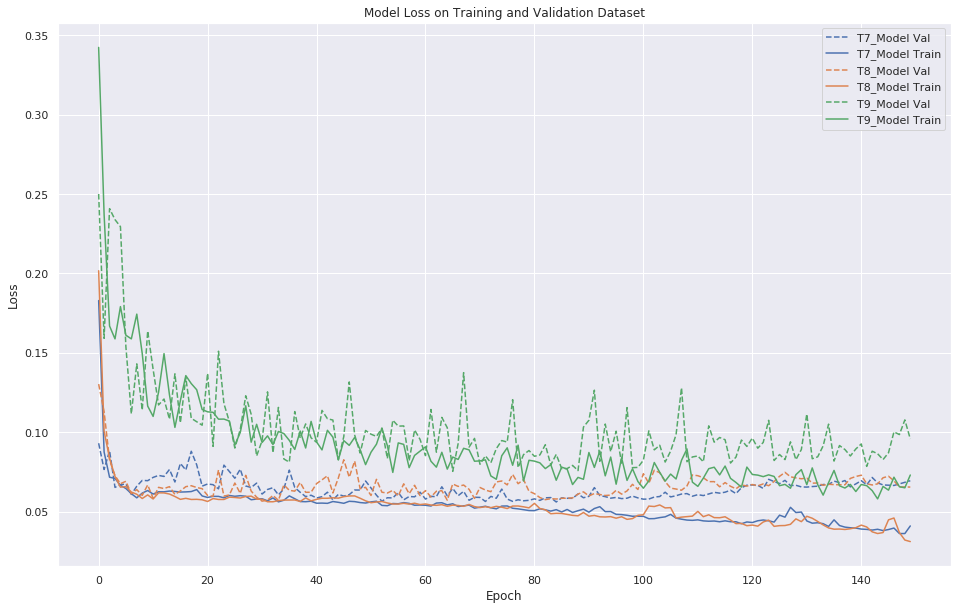

In [51]:
# Loss plot of t7_model, t8_model and t9_model
compSet = [('t7_model', t7_history),('t8_model', t8_history),('t9_model', t9_history)]
plt.figure(figsize=(16,10))

for modelName, historyName in compSet:
    valPlot = plt.plot(historyName.history['val_loss'], linestyle = '--', label=modelName.title() + ' Val')
    plt.plot(historyName.history['loss'], color=valPlot[0].get_color(), label=modelName.title() + ' Train')

plt.title('Model Loss on Training and Validation Dataset')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

**Observations:**
* t9_model training and testing loss are much higher than the rest 2 models, and it performance fluctuate  over epochs, indicate its learing process is not stable
* t7_model and t8_model performance are close to each other, both of them have significant overfitting issue after epoch 100, will add drop out rate to eliminate this impact in next step

**t10_model**
* Change made based on **t7_model**
* Set recurrent_dropout=0.3
* Decrease epoch number to 100

In [52]:
# design network
t10_model = Sequential()
t10_model.add(LSTM(200,recurrent_dropout=0.3,input_shape=(timesteps, data_dim)))
t10_model.add(Dense(1, activation='linear'))

t10_model.compile(loss='mae', optimizer='adam')

# fit network
t10_history = t10_model.fit(x_train, y_train, batch_size=250,  epochs=100, validation_data=(x_valid, y_valid), shuffle=False)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 43782 samples, validate on 8760 samples
Epoch 1/100
43782/43782 [==============================] - 16s 371us/step - loss: 0.1878 - val_loss: 0.0913
Epoch 2/100
43782/43782 [==============================] - 10s 224us/step - loss: 0.0957 - val_loss: 0.0749
Epoch 3/100
43782/43782 [==============================] - 10s 226us/step - loss: 0.0855 - val_loss: 0.0707
Epoch 4/100
43782/43782 [==============================] - 10s 224us/step - loss: 0.0801 - val_loss: 0.0723
Epoch 5/100
43782/43782 [==============================] - 10s 225us/step - loss: 0.0761 - val_loss: 0.0850
Epoch 6/100
43782/43782 [==============================] - 10s 223us/step - loss: 0.0776 - val_loss: 0.0792
Epoch 7/100
43782/43782 [==============================] - 10s 224us/step - loss: 0.0794 - val_loss: 0.0664
Epoch 8/100
43782/43782 [==============================] - 10s 222us/step - loss

~~~python
t9_model
Epoch 98/100
43782/43782 [==============================] - 10s 226us/step - loss: 0.0605 - val_loss: 0.0581
Epoch 99/100
43782/43782 [==============================] - 10s 225us/step - loss: 0.0640 - val_loss: 0.0603
Epoch 100/100
43782/43782 [==============================] - 10s 224us/step - loss: 0.0583 - val_loss: 0.0617
~~~

In [53]:
y_test = pd.read_csv('../input/sample/sample_submission_2019spring.csv')

y_test['temperature'] = t10_model.predict(x_test)
y_test['temperature'] = y_test['temperature']*std+me
y_test.to_csv("t10_output.csv", index = False)

create_download_link(filename='"t10_output.csv".csv')

**t11_model**
* Change made based on **t8_model**
* Set recurrent_dropout=0.3
* Decrease epoch number to 100

In [54]:
t11_model = Sequential()
t11_model.add(Bidirectional(LSTM(200,recurrent_dropout=0.3),input_shape=(timesteps, data_dim)))
t11_model.add(Dense(1, activation='linear'))

t11_model.compile(loss='mae', optimizer='adam')

# fit network
t11_history = t11_model.fit(x_train, y_train, batch_size=250,  epochs=100, validation_data=(x_valid, y_valid), shuffle=False)

Train on 43782 samples, validate on 8760 samples
Epoch 1/100
43782/43782 [==============================] - 26s 603us/step - loss: 0.2035 - val_loss: 0.1341
Epoch 2/100
43782/43782 [==============================] - 19s 429us/step - loss: 0.1090 - val_loss: 0.1273
Epoch 3/100
43782/43782 [==============================] - 19s 428us/step - loss: 0.0978 - val_loss: 0.0937
Epoch 4/100
43782/43782 [==============================] - 19s 436us/step - loss: 0.0849 - val_loss: 0.0781
Epoch 5/100
43782/43782 [==============================] - 19s 434us/step - loss: 0.0786 - val_loss: 0.0678
Epoch 6/100
43782/43782 [==============================] - 19s 430us/step - loss: 0.0771 - val_loss: 0.0704
Epoch 7/100
43782/43782 [==============================] - 19s 430us/step - loss: 0.0733 - val_loss: 0.0636
Epoch 8/100
43782/43782 [==============================] - 19s 430us/step - loss: 0.0737 - val_loss: 0.0642
Epoch 9/100
43782/43782 [==============================] - 19s 430us/step - loss: 0.073

Epoch 76/100
43782/43782 [==============================] - 19s 428us/step - loss: 0.0577 - val_loss: 0.0594
Epoch 77/100
43782/43782 [==============================] - 19s 429us/step - loss: 0.0582 - val_loss: 0.0581
Epoch 78/100
43782/43782 [==============================] - 19s 430us/step - loss: 0.0608 - val_loss: 0.0595
Epoch 79/100
43782/43782 [==============================] - 19s 431us/step - loss: 0.0605 - val_loss: 0.0590
Epoch 80/100
43782/43782 [==============================] - 19s 431us/step - loss: 0.0579 - val_loss: 0.0575
Epoch 81/100
43782/43782 [==============================] - 19s 429us/step - loss: 0.0592 - val_loss: 0.0592
Epoch 82/100
43782/43782 [==============================] - 19s 430us/step - loss: 0.0598 - val_loss: 0.0610
Epoch 83/100
43782/43782 [==============================] - 19s 429us/step - loss: 0.0586 - val_loss: 0.0589
Epoch 84/100
43782/43782 [==============================] - 19s 426us/step - loss: 0.0598 - val_loss: 0.0592
Epoch 85/100
43782/

~~~python
Epoch 98/100
43782/43782 [==============================] - 19s 433us/step - loss: 0.0588 - val_loss: 0.0613
Epoch 99/100
43782/43782 [==============================] - 19s 428us/step - loss: 0.0579 - val_loss: 0.0584
Epoch 100/100
43782/43782 [==============================] - 19s 430us/step - loss: 0.0573 - val_loss: 0.0591
~~~

In [55]:
y_test = pd.read_csv('../input/sample/sample_submission_2019spring.csv')

y_test['temperature'] = t11_model.predict(x_test)
y_test['temperature'] = y_test['temperature']*std+me
y_test.to_csv("t11_output.csv", index = False)

create_download_link(filename='"t11_output.csv".csv')

### 5-C. Optimal Models performance visualization 

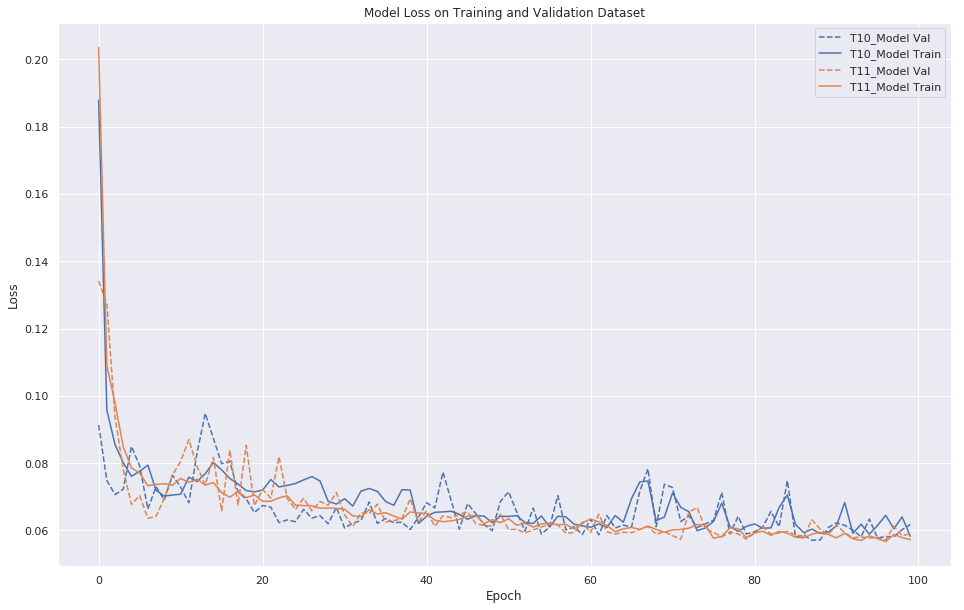

In [56]:
# Loss plot of t10_model, t11_model
compSet = [('t10_model', t10_history),('t11_model', t11_history)]
plt.figure(figsize=(16,10))

for modelName, historyName in compSet:
    valPlot = plt.plot(historyName.history['val_loss'], linestyle = '--', label=modelName.title() + ' Val')
    plt.plot(historyName.history['loss'], color=valPlot[0].get_color(), label=modelName.title() + ' Train')

plt.title('Model Loss on Training and Validation Dataset')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

### 5-D. Define final model

In [57]:
final_model = t11_model

## 6. Predictions   
Use the final model to predict from "02.01.2015 00:00:00" (Jan 2, 2015 0:00 am) to "01.01.2017 00:00:00" (Jan 1, 2017 0:00 am)<br>
**NOTE: Re-scale the predictions back to original scale** <br>
(To wit, use mean=10.25075 and stdev=8.01432.)

In [58]:
me = 10.25075
std = 8.01432
y_test = pd.read_csv('../input/sample/sample_submission_2019spring.csv')

y_test['temperature'] = final_model.predict(x_test)
y_test['temperature'] = y_test['temperature']*std+me
y_test.to_csv("final_output.csv", index = False)

create_download_link(filename='"final_output.csv".csv')